In [3]:
import os
import cv2
import numpy as np
import tensorflow as tf
import mediapipe as mp
import matplotlib.pyplot as plt
import time
# Directorios para entrenamiento, validación y prueba
train_dir = 'new_dataset/train' 
NP_PATH = 'new_dataset/NP_PATH'

actions = []

# creating data training folders

In [37]:
## creating folders for the landmarks for each frame of each video
try:
    for action in os.listdir(train_dir):
        action_path = os.path.join(train_dir, action)
        if os.path.isdir(action_path):
            print(f"Processing action: {action}")
            actions.append(action)
    # for action in actions:
    #     action_path=os.path.join(NP_PATH, action)
    #     os.makedirs(action_path, exist_ok=True)
    #     print(f'creando:{action_path}')
    #     for video in range(5):
    #         video_path=os.path.join(action_path, str(video))
    #         os.makedirs(video_path, exist_ok=True)
    #         print(f'creando:{video_path}')
except Exception as e:
    print(e)

Processing action: Aprender
Processing action: Ayuda
Processing action: Bien
Processing action: Buenas noches
Processing action: Buenos dias
Processing action: Comer
Processing action: Como estas
Processing action: Como te llamas
Processing action: Cuando
Processing action: Donde
Processing action: Entiendo
Processing action: Feliz
Processing action: Gracias
Processing action: Hasta luego
Processing action: Hola
Processing action: Igual
Processing action: Mal
Processing action: Me gusta
Processing action: No
Processing action: No puedo
Processing action: No quiero
Processing action: Ocupado
Processing action: Otra vez
Processing action: Para que
Processing action: Perdon
Processing action: Por favor
Processing action: Por que
Processing action: Pregunta
Processing action: Puedo
Processing action: Que
Processing action: Que pasa
Processing action: Quien
Processing action: Quiero
Processing action: Si
Processing action: Tu
Processing action: Yo
Processing action: Yo no se
Processing acti

# Preprocesing data training

In [18]:
mp_holistic = mp.solutions.holistic  # Modelo Holístico

def draw_landmarks(image, results_holistic):
    mp_drawing = mp.solutions.drawing_utils  # Utilidades de dibujo

    # Configuración para líneas más delgadas
    landmark_drawing_spec = mp_drawing.DrawingSpec(thickness=1, circle_radius=1)
    connection_drawing_spec = mp_drawing.DrawingSpec(thickness=1)

    if results_holistic.pose_landmarks:
        mp_drawing.draw_landmarks(
            image, results_holistic.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
            landmark_drawing_spec=landmark_drawing_spec,
            connection_drawing_spec=connection_drawing_spec)
    
    if results_holistic.left_hand_landmarks:
        mp_drawing.draw_landmarks(
            image, results_holistic.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
            landmark_drawing_spec=landmark_drawing_spec,
            connection_drawing_spec=connection_drawing_spec)
    
    if results_holistic.right_hand_landmarks:
        mp_drawing.draw_landmarks(
            image, results_holistic.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
            landmark_drawing_spec=landmark_drawing_spec,
            connection_drawing_spec=connection_drawing_spec)
    
    return image

def extract_keypoints(results_holistic):
    # Extracción de keypoints de la pose
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results_holistic.pose_landmarks.landmark]).flatten() if results_holistic.pose_landmarks else np.zeros(33*4)
    
    # Extracción de keypoints de la mano izquierda
    lh = np.zeros(21*3)
    if results_holistic.left_hand_landmarks:
        lh = np.array([[res.x, res.y, res.z] for res in results_holistic.left_hand_landmarks.landmark]).flatten()
    
    # Extracción de keypoints de la mano derecha
    rh = np.zeros(21*3)
    if results_holistic.right_hand_landmarks:
        rh = np.array([[res.x, res.y, res.z] for res in results_holistic.right_hand_landmarks.landmark]).flatten()
    
    return np.concatenate([pose, lh, rh])
 
    
def process_all_videos(root_path, sequence_length):
    """
    Procesa todos los videos en los subdirectorios de la ruta raíz especificada.
    
    Args:
    root_path (str): Ruta al directorio raíz que contiene las carpetas de videos.
    sequence_length (int): Número de frames a procesar por video.
    NP_PATH (str): Ruta donde se guardarán los archivos numpy con los keypoints.
    """
    # Configuración de MediaPipe
    actions = []

    with mp_holistic.Holistic(
        static_image_mode=False,
        model_complexity=2,                 # 0 para más rápido, 2 para más preciso
        smooth_landmarks=True,
        min_detection_confidence=0.6,       # Aumentar el umbral para reducir falsos positivos
        min_tracking_confidence=0.6) as holistic:
        
        for action in os.listdir(root_path):
            action_path = os.path.join(root_path, action)
            if os.path.isdir(action_path):
                print(f"Processing action: {action}")
                num_video =0
                for video in os.listdir(action_path):
                    if video.endswith(('.mp4', '.avi', '.mov')):
                        video_path = os.path.join(action_path, video)
                        process_video(video_path, holistic, action, num_video, sequence_length)
                        num_video+=1
        print("Processed actions:", actions)



def process_video(video_path, holistic, action, video, sequence_length):
    """
    Procesa un único video y extrae los landmarks.
    
    Args:
    video_path (str): Ruta al archivo de video a procesar.
    hands (mediapipe.solutions.hands.Hands): Instancia de MediaPipe Hands.
    pose (mediapipe.solutions.pose.Pose): Instancia de MediaPipe Pose.
    action (str): Nombre de la acción (directorio padre del video).
    video (str): Nombre del archivo de video.
    sequence_length (int): Número de frames a procesar por video.
    NP_PATH (str): Ruta donde se guardarán los archivos numpy con los keypoints.
    """
    cap = cv2.VideoCapture(video_path)
    sequence_length=34, frame_size=(64, 64)
    frames= []
    # Crear una ventana para mostrar el video
    window_name = f"Processing: {action} - {video}"
    cv2.namedWindow(window_name, cv2.WINDOW_NORMAL)
    cv2.resizeWindow(window_name, 640, 720)

    for frame_num in range(sequence_length):
        success, image = cap.read()
        if not success:
            break
        
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results_holistic = holistic.process(image_rgb)
        
        # Dibujar los landmarks en la imagen
        image_with_landmarks = draw_landmarks(image, results_holistic)
        
        # Mostrar la imagen procesada
        cv2.imshow(window_name, image_with_landmarks)
        
        if frame_num == 0:
            cv2.waitKey(500)
        else:
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
        
        keypoints = extract_keypoints(results_holistic)
        npy_path = os.path.join(NP_PATH, action, str(video), str(frame_num))
        np.save(npy_path, keypoints)
    


    cap.release()
    cv2.destroyWindow(window_name)
    print(f"Processed {frame_num + 1} frames from {video_path}")
    # Agregar una pausa de 2 segundos entre videos
    time.sleep(2)




In [ ]:
# running the function

process_all_videos(train_dir, 34) 


In [39]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import pandas as pd
import json


In [40]:
actions = list(pd.Series(actions).unique())
label_map = {label:num for num, label in enumerate(actions)}
with open('datos.json', 'w') as f:
    json.dump(label_map, f)

In [41]:
label_map

{'Aprender': 0,
 'Ayuda': 1,
 'Bien': 2,
 'Buenas noches': 3,
 'Buenos dias': 4,
 'Comer': 5,
 'Como estas': 6,
 'Como te llamas': 7,
 'Cuando': 8,
 'Donde': 9,
 'Entiendo': 10,
 'Feliz': 11,
 'Gracias': 12,
 'Hasta luego': 13,
 'Hola': 14,
 'Igual': 15,
 'Mal': 16,
 'Me gusta': 17,
 'No': 18,
 'No puedo': 19,
 'No quiero': 20,
 'Ocupado': 21,
 'Otra vez': 22,
 'Para que': 23,
 'Perdon': 24,
 'Por favor': 25,
 'Por que': 26,
 'Pregunta': 27,
 'Puedo': 28,
 'Que': 29,
 'Que pasa': 30,
 'Quien': 31,
 'Quiero': 32,
 'Si': 33,
 'Tu': 34,
 'Yo': 35,
 'Yo no se': 36,
 'Yo se': 37}

In [59]:
print(len(actions))

38


In [42]:
try:
    sequences, labels = [], []
    for action in actions:
        print(action)
        for sequence in np.array(os.listdir(os.path.join(NP_PATH, action))).astype(int):
            print(sequence)
            window = []
            for frame_num in range(34):
                print(frame_num)
                res = np.load(os.path.join(NP_PATH, action, str(sequence), "{}.npy".format(frame_num)))
                window.append(res)
            sequences.append(window)
            labels.append(label_map[action])
except Exception as e:
    print(e)

Aprender
0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
1
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
2
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
3
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
4
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
Ayuda
0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
1
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
2
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
3
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
4
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
Bien
0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


In [43]:
np.array(sequences).shape

(190, 34, 258)

In [44]:
np.array(labels).shape

(190,)

In [45]:
X = np.array(sequences)
y = to_categorical(labels).astype(int)


In [311]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.07)

In [114]:
y_train.shape

(176, 38)

In [115]:
X_train.shape

(176, 34, 258)

In [309]:
y_test.shape

(14, 38)

In [292]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.regularizers import l2 
from tensorflow.keras.optimizers import Adam
from keras import Input
from tensorflow.keras import layers, models
from keras.layers import Bidirectional
from sklearn.model_selection import KFold

In [293]:
k = 3  # Número de pliegues
kf = KFold(n_splits=k, shuffle=True, random_state=42)  # Ajusta random_state si es necesario


In [49]:
print(len(actions))

38


# model

In [301]:

log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)


num_classes = 38  # Ejemplo, depende del número de clases en tu tarea
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# Definir el callback de Early Stopping
early_stopping = EarlyStopping(
    monitor='val_categorical_accuracy',  # Métrica a monitorear
    patience=50,         # Número de épocas a esperar antes de detener si no hay mejora
    restore_best_weights=True,  # Restaurar los mejores pesos encontrados
    verbose=1            # Mostrar mensaje cuando se detenga el entrenamiento
)


model = models.Sequential()

model.add(Input(shape=(34,258, 1)))

# Primera capa de convolución 2D
model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu'))
# model.add(BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Segunda capa de convolución 2D
model.add(layers.Conv2D(68, kernel_size=(3, 2), activation='relu'))
# model.add(BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))


# Tercera capa de convolución 2D
model.add(layers.Conv2D(136, kernel_size=(3, 1), activation='relu'))
# model.add(BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Aplanar las características 2D para hacerlas compatibles con LSTM
model.add(layers.Flatten())

# Imprimir la forma de salida después de la capa Flatten
print("Output shape after Flatten:", model.output_shape)

# Obtener el tamaño aplanado
flattened_size = model.output_shape[-1]

# Asegurarse de que el tamaño aplanado sea divisible por 34
if flattened_size % 34 != 0:
    raise ValueError(f"flattened_size {flattened_size} no es divisible por 34.")

# Expandir la dimensión de salida para que la LSTM procese una secuencia
model.add(layers.Reshape((34, flattened_size // 34)))

# Capa LSTM bidireccional
model.add(Bidirectional(layers.LSTM(64, return_sequences=True, activation='relu')))
# model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.4))

model.add(Bidirectional(layers.LSTM(128, return_sequences=False, activation='relu')))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))

model.add(layers.Dense(64, activation='relu', kernel_regularizer=l2(0.04)))

model.add(layers.Dense(num_classes, activation='softmax'))



# Compilar el modelo


# model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(34, 258)))
# model.add(LSTM(128, return_sequences=True, activation='relu'))
# model.add(Dropout(0.3))
# model.add(LSTM(64, return_sequences=False, kernel_regularizer=l2(0.03)))
# model.add(BatchNormalization())  # Normalización para mejorar la convergencia
# model.add(Dropout(0.5))  # Regularización para evitar overfitting
# model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.03)))
# model.add(Dense(38, activation='softmax'))  # 38 clases




# model = Sequential()
# model.add(Input(shape=(34,258)))
# model.add(LSTM(32, return_sequences=True, activation='relu', ))
# model.add(LSTM(64, return_sequences=True, activation='relu'))
# model.add(BatchNormalization())
# model.add(LSTM(128, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.3))
# model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
# model.add(Dense(38, activation='softmax'))
# model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])




model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])



Output shape after Flatten: (None, 8432)


In [302]:
# Almacenar los resultados
results = []
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # Asegúrate de que X_train tenga la forma correcta para Conv2D
    X_train = X_train.reshape(-1, 34, 258, 1)
    X_val = X_val.reshape(-1, 34, 258, 1)
    # Ajustar el modelo con Early Stopping
    history = model.fit(X_train, y_train, 
            epochs=200, 
            batch_size=8,
            validation_data=(X_val, y_val),
            # validation_split= 0.2,#(X_train, y_train),  # Usar 10% de los datos para validación
            callbacks=[tb_callback, early_stopping]) #reduce_lr  

    # Evaluar en el conjunto de prueba

    val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
    results.append(val_accuracy)
# Mostrar los resultados de cada pliegue
print("Precisión media en los pliegues:", np.mean(results))
print("Desviación estándar de la precisión:", np.std(results))

Epoch 1/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 94ms/step - categorical_accuracy: 0.0219 - loss: 7.4831 - val_categorical_accuracy: 0.0469 - val_loss: 6.7042
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - categorical_accuracy: 0.0424 - loss: 6.4817 - val_categorical_accuracy: 0.0000e+00 - val_loss: 5.9324
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - categorical_accuracy: 0.0157 - loss: 5.7130 - val_categorical_accuracy: 0.0000e+00 - val_loss: 5.3890
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - categorical_accuracy: 0.0180 - loss: 5.0762 - val_categorical_accuracy: 0.0000e+00 - val_loss: 5.0030
Epoch 5/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - categorical_accuracy: 0.1460 - loss: 4.5586 - val_categorical_accuracy: 0.0000e+00 - val_loss: 4.7367
Epoch 6/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - categorical_accuracy: 0.0775 - loss: 4.3664 - val_categorical_accuracy: 0.0000e+00 - val_loss: 4.5233
Epoch 7/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - categorical_ac

# Tensorboard plot

In [332]:
val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=1)
print(val_accuracy)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - categorical_accuracy: 0.9788 - loss: 0.5488
0.9682539701461792


In [331]:

from tensorboard import program
import webbrowser

# Inicia TensorBoard
tb = program.TensorBoard()

tb.configure(argv=[None, '--logdir', 'Logs/train'])
url = tb.launch()
print(f"TensorBoard iniciado en {url}")


TensorBoard iniciado en http://localhost:6006/


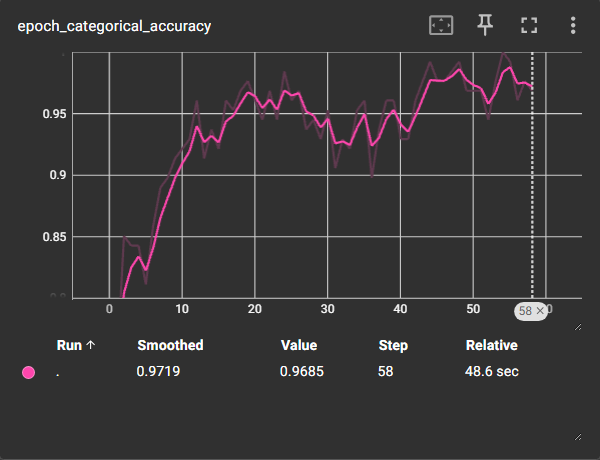

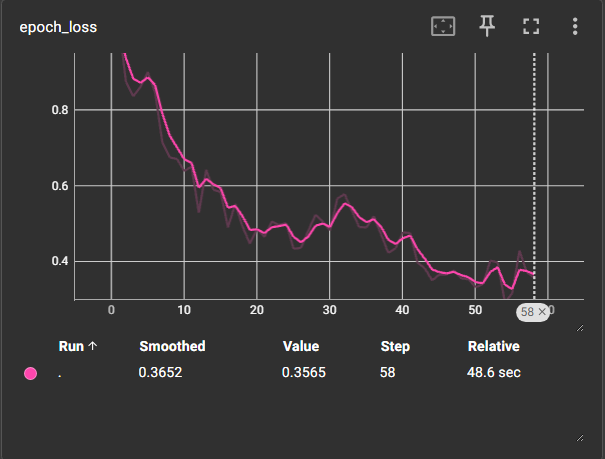

In [316]:
model.summary()

Model: "sequential_147"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_331 (Conv2D)             │ (None, 32, 256, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_332               │ (None, 16, 128, 32)    │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_332 (Conv2D)             │ (None, 14, 127, 68)    │        13,124 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_333               │ (None, 7, 63, 68)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_333 (Conv2D)             │ (None, 5, 63, 136)     │        27,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_334               │ (None, 2, 31, 136)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_134 (Flatten)           │ (None, 8432)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_122 (Reshape)           │ (None, 34, 248)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_30                │ (None, 34, 128)        │       160,256 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_193 (Dropout)           │ (None, 34, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_31                │ (None, 256)            │       263,168 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_140         │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_194 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_260 (Dense)               │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_261 (Dense)               │ (None, 38)             │         2,470 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,453,048 (5.54 MB)

 Trainable params: 484,178 (1.85 MB)

 Non-trainable params: 512 (2.00 KB)

 Optimizer params: 968,358 (3.69 MB)

In [341]:
results = model.predict(X_test)
results

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


array([[1.35204027e-04, 1.10847304e-06, 6.78562064e-05, 4.29537176e-05,
        2.66333814e-07, 7.04948548e-07, 2.94768802e-06, 2.32507432e-06,
        1.36120274e-04, 2.11632252e-02, 9.00763378e-04, 9.53257736e-03,
        6.36818586e-04, 5.50497243e-05, 1.87060448e-06, 1.95171451e-05,
        5.51828146e-02, 9.00477886e-01, 3.54484291e-05, 3.66247406e-07,
        1.83745051e-05, 4.57769638e-04, 2.29404777e-05, 1.86178127e-07,
        6.79629808e-03, 9.01431136e-04, 4.45078786e-06, 1.06695911e-03,
        3.54010467e-06, 1.66361751e-05, 7.48106186e-06, 1.95641158e-04,
        1.35724340e-03, 9.13565771e-07, 7.29734544e-04, 2.41374910e-05,
        6.36025774e-08, 3.17080207e-07],
       [7.30158528e-03, 2.14528874e-03, 3.83695806e-05, 8.17314256e-03,
        2.53633950e-02, 1.31089753e-03, 1.02190839e-04, 1.11127915e-02,
        1.00194025e-04, 5.64520960e-05, 5.17661683e-05, 2.74298456e-03,
        1.32342400e-02, 3.91060195e-04, 1.10987567e-05, 4.89717931e-04,
        2.92679612e-02,

In [342]:
actions[np.argmax(results[7])]

'Perdon'

In [343]:
actions[np.argmax(y_test[7])]

'Perdon'

In [333]:
model.save('model_kfolding(97train-96val).keras')

In [334]:
## deleting model from the buffer
del model

In [335]:
import keras
model=keras.models.load_model('model_kfolding(97train-96val).keras')

In [327]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [336]:
yhat = model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step


In [337]:
ytrue = np.argmax(y_test, axis=1).tolist()

yhat = np.argmax(yhat, axis=1).tolist()

In [338]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[13,  0],
        [ 0,  1]],

       [[12,  0],
        [ 0,  2]],

       [[13,  0],
        [ 0,  1]],

       [[12,  0],
        [ 0,  2]],

       [[12,  0],
        [ 0,  2]],

       [[13,  0],
        [ 0,  1]],

       [[13,  0],
        [ 0,  1]],

       [[13,  0],
        [ 0,  1]],

       [[13,  0],
        [ 0,  1]],

       [[13,  0],
        [ 0,  1]],

       [[13,  0],
        [ 0,  1]]], dtype=int64)

In [339]:
accuracy_score(ytrue, yhat)

1.0

In [340]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [ ]:
import cv2
import numpy as np
import mediapipe as mp
from tensorflow.keras.models import load_model
from collections import deque
import time


last_prediction_time = 0
prediction_interval = 1

sequence = []
sentence = []
predictions = []
threshold = 0.5
mp_hands = mp.solutions.hands
mp_pose = mp.solutions.pose
hands = mp_hands.Hands()
pose = mp_pose.Pose()

# def draw_landmarks(image, results_hands, results_pose):
#     mp_drawing = mp.solutions.drawing_utils
#     mp_hands = mp.solutions.hands
#     mp_pose = mp.solutions.pose
#     if results_pose.pose_landmarks:
#         mp_drawing.draw_landmarks(
#             image, results_pose.pose_landmarks, mp_pose.POSE_CONNECTIONS)
#     if results_hands.multi_hand_landmarks:
#         for hand_landmarks in results_hands.multi_hand_landmarks:
#             mp_drawing.draw_landmarks(
#                 image, hand_landmarks, mp_hands.HAND_CONNECTIONS)
#     return image
def draw_landmarks(image, results_hands, results_pose):
    mp_drawing = mp.solutions.drawing_utils
    mp_hands = mp.solutions.hands
    mp_pose = mp.solutions.pose

    # Configuración para líneas más delgadas
    landmark_drawing_spec = mp_drawing.DrawingSpec(thickness=1, circle_radius=1)
    connection_drawing_spec = mp_drawing.DrawingSpec(thickness=1)

    if results_pose.pose_landmarks:
        mp_drawing.draw_landmarks(
            image, results_pose.pose_landmarks, mp_pose.POSE_CONNECTIONS,
            landmark_drawing_spec=landmark_drawing_spec,
            connection_drawing_spec=connection_drawing_spec)
    
    if results_hands.multi_hand_landmarks:
        for hand_landmarks in results_hands.multi_hand_landmarks:
            mp_drawing.draw_landmarks(
                image, hand_landmarks, mp_hands.HAND_CONNECTIONS,
                landmark_drawing_spec=landmark_drawing_spec,
                connection_drawing_spec=connection_drawing_spec)
    
    return image

def extract_keypoints(results_hands, results_pose):
    # # pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results_pose.pose_landmarks.landmark]).flatten() if results_pose.pose_landmarks else np.zeros(33*4)
    
    # # if results_hands.multi_hand_landmarks:
    # #     lh = np.array([[res.x, res.y, res.z] for res in results_hands.multi_hand_landmarks[0].landmark]).flatten()
    # #     if len(results_hands.multi_hand_landmarks) > 1:
    # #         rh = np.array([[res.x, res.y, res.z] for res in results_hands.multi_hand_landmarks[1].landmark]).flatten()
    # #     else:
    # #         rh = np.zeros(21*3)
    # # else:
    # #     lh = np.zeros(21*3)
    # #     rh = np.zeros(21*3)
    
    # # return np.concatenate([pose, lh, rh])
    # pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results_pose.pose_landmarks.landmark]).flatten() if results_pose.pose_landmarks else np.zeros(33*4)
    # lh = np.array([[res.x, res.y, res.z] for res in results_hands.left_hand_landmarks.landmark]).flatten() if results_hands.left_hand_landmarks else np.zeros(21*3)
    # rh = np.array([[res.x, res.y, res.z] for res in results_hands.right_hand_landmarks.landmark]).flatten() if results_hands.right_hand_landmarks else np.zeros(21*3)
    # return np.concatenate([pose, lh, rh])
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results_pose.pose_landmarks.landmark]).flatten() if results_pose.pose_landmarks else np.zeros(33*4)
    
    lh = np.zeros(21*3)
    rh = np.zeros(21*3)
    
    if results_hands.multi_hand_landmarks:
        for idx, hand_landmarks in enumerate(results_hands.multi_hand_landmarks):
            hand = np.array([[res.x, res.y, res.z] for res in hand_landmarks.landmark]).flatten()
            if idx == 0:
                lh = hand
            elif idx == 1:
                rh = hand
    
    return np.concatenate([pose, lh, rh])


def prob_viz(res, actions, image, color):
    output_image = image.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_image, (0, 60+num*40), (int(prob*100), 90+num*40), color, -1)
        cv2.putText(output_image, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    return output_image

# Define un solo color para todas las acciones (por ejemplo, azul)
action_color = (255, 0, 0)  # BGR format (Blue)




# Captura de video
cap = cv2.VideoCapture(0)

while cap.isOpened():
    success, image = cap.read()
    if not success:
        break
    
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results_hands = hands.process(image_rgb)
    results_pose = pose.process(image_rgb)
    
    # Dibujar los landmarks en la imagen
    image_with_landmarks = draw_landmarks(image, results_hands, results_pose)
    
    # Verificar si se detecta una mano
    if results_hands.multi_hand_landmarks:
        # Extraer keypoints
        keypoints = extract_keypoints(results_hands, results_pose)
        
        # Añadir keypoints a la secuencia y mantener solo los últimos 33
        sequence.append(keypoints)
        sequence = sequence[-33:]
        current_time = time.time()
        if len(sequence) == 33 and current_time - last_prediction_time >= prediction_interval:
            # Realizar predicción
            input_data = np.expand_dims(sequence, axis=0)
            res = model.predict(input_data)[0]
            predicted_action = actions[np.argmax(res)]
            print(predicted_action)
            predictions.append(np.argmax(res))
            sequence.clear()  # Limpiar la secuencia cuando no se detecta mano
            
            # Lógica de visualización
            if np.unique(predictions[-10:])[0] == np.argmax(res):
                if res[np.argmax(res)] > threshold:
                    if len(sentence) > 0:
                        if predicted_action != sentence[-1]:
                            sentence.append(predicted_action)
                    else:
                        sentence.append(predicted_action)
            
            
            # Visualizar probabilidades
            image_with_landmarks = prob_viz(res, actions, image_with_landmarks, action_color)
            last_prediction_time = current_time
        # Mostrar la predicción en la imagen
        cv2.rectangle(image_with_landmarks, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image_with_landmarks, ' '.join(sentence), (3,30), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
    else:
        # No se detecta mano
        sequence.clear()  # Limpiar la secuencia cuando no se detecta mano
        cv2.putText(image_with_landmarks, 'No hand detected', (10, 30), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)
    
    # Mostrar la imagen procesada
    cv2.imshow('Real-time Prediction', image_with_landmarks)
    
    # Salir si se presiona 'q'
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

In [58]:
cap.release()
cv2.destroyAllWindows()